<a href="https://colab.research.google.com/github/FalineRezvani/Classification/blob/main/AdaBoost_IMDbReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

September 17, 2024

This notebook will use the IMDb Review dataset to train, test, and evaluate an Adaptive Boosting (Ada Boost) classification model for sentiment analysis.

The dataset can be obtained from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
# Importing essential Libraries:
# NumPy is used for numerical computations and working with arrays;
# Pandas is used for data manipulation and analysis;
# Regular expressions (re) is used to specify & match a set of characters.
import numpy as np
import pandas as pd
import re, string
import nltk
import csv

In [54]:
with open('IMDB_Dataset.csv', 'r') as file:
  text = csv.reader(file)

In [19]:
# Making columns with index [0] of the .csv file.
header = []
header = next(text)
print(header)

['review', 'sentiment']


In [20]:
# Creating the pandas DataFrame using header created above to assign columns.
df = pd.DataFrame(text, columns=[header])

# Verifying DataFrame row and column count.
print(df)

                                                 review sentiment
0     One of the other reviewers has mentioned that ...  positive
1     A wonderful little production. <br /><br />The...  positive
2     I thought this was a wonderful way to spend ti...  positive
3     Basically there's a family where a little boy ...  negative
4     Petter Mattei's "Love in the Time of Money" is...  positive
...                                                 ...       ...
8679  The BBC'S Blue Planet is simply jaw-dropping. ...  positive
8680  I mistakenly kept myself awake late last night...  negative
8681  Its my favourite film because there's so much ...  positive
8682  As long as you go into this movie knowing that...  positive
8683  The legend of Andrei Konchalovsky's towering 4...      None

[8684 rows x 2 columns]


__Exploratory Data Analysis__

In [21]:
# Removing NA's.
df = df.dropna()

In [ ]:
df.shape

(8683, 2)

In [ ]:
df.columns

MultiIndex([(   'review',),
            ('sentiment',)],
           )

In [ ]:
print(df['review'])

                                                 review
0     One of the other reviewers has mentioned that ...
1     A wonderful little production. <br /><br />The...
2     I thought this was a wonderful way to spend ti...
3     Basically there's a family where a little boy ...
4     Petter Mattei's "Love in the Time of Money" is...
...                                                 ...
8678  In Strangers On A Train, it's obvious from the...
8679  The BBC'S Blue Planet is simply jaw-dropping. ...
8680  I mistakenly kept myself awake late last night...
8681  Its my favourite film because there's so much ...
8682  As long as you go into this movie knowing that...

[8683 rows x 1 columns]


In [ ]:
print(df.iloc[:, 0])

0       One of the other reviewers has mentioned that ...
1       A wonderful little production. <br /><br />The...
2       I thought this was a wonderful way to spend ti...
3       Basically there's a family where a little boy ...
4       Petter Mattei's "Love in the Time of Money" is...
                              ...                        
8678    In Strangers On A Train, it's obvious from the...
8679    The BBC'S Blue Planet is simply jaw-dropping. ...
8680    I mistakenly kept myself awake late last night...
8681    Its my favourite film because there's so much ...
8682    As long as you go into this movie knowing that...
Name: (review,), Length: 8683, dtype: object


In [ ]:
print(df['sentiment'])

     sentiment
0     positive
1     positive
2     positive
3     negative
4     positive
...        ...
8678  positive
8679  positive
8680  negative
8681  positive
8682  positive

[8683 rows x 1 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8683 entries, 0 to 8682
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   (review,)     8683 non-null   object
 1   (sentiment,)  8683 non-null   object
dtypes: object(2)
memory usage: 135.8+ KB


In [ ]:
df.index

RangeIndex(start=0, stop=8683, step=1)

In [ ]:
df['sentiment'].value_counts()

,count
"(sentiment,)",
positive,4359
negative,4324


In [ ]:
df.isnull().sum()

,0
review,0
sentiment,0


__Label Encoding__

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
# Instantiating label encoder.
le = LabelEncoder()

In [24]:
# Fitting to target variable, 'sentiment' (label/class).
df['sentiment'] = le.fit_transform(df[['sentiment']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
# Checking that we only have two classes.
le.classes_

array(['negative', 'positive'], dtype=object)

In [26]:
# Counting instances of our label (dependent/target variable), 'sentiment'.
# 1 - positive, 0 - negative
df['sentiment'].value_counts()

,count
"(sentiment,)",
1,4359
0,4324


In [ ]:
print(df.iloc[:, 1])

0       1
1       1
2       1
3       0
4       1
       ..
8678    1
8679    1
8680    0
8681    1
8682    1
Name: (sentiment,), Length: 8683, dtype: int64


__Download English Stop Words and Remove 'Not'__

In [27]:
# Downloading NLTK stopwords data.
# Stop words are commonly used in human language, such as contractions, yet not useful to meaning.
nltk.download('stopwords')
from nltk.corpus import stopwords

# Importing the Porter stemming algorithm to strip suffixes
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Removing 'not' from English stop words list.
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
'not' in stop_words

False

__Creating Corpus from DataFrame__

In [29]:
corpus = []

for i in range(0, 8683):
  review = re.compile('<.*?>').sub(repl=' ', string=df.iloc[:,0][i])
  review = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', review)
  review = review.lower()
  corpus.append(review)

In [ ]:
# Verifying corpus.
#corpus[:5]

__Vectorizing/embedding Corpus & Assigning Arrays to X and y Variables__

In [30]:
# Importing the CountVectorizer class from scikit-learn, which is used to convert text data into numerical features.
from sklearn.feature_extraction.text import CountVectorizer

# Word embedding, or vectorization, represents semantics and syntax numerically.
# Instatiating CountVectorizer with a specified maximum number of features to be included in vocabulary.
cv = CountVectorizer(max_features=5000)

# Putting corpus in an array containing numerical representations of
# the text data to be used as input, or the 'X' variable, for our model.
X = cv.fit_transform(corpus).toarray()

# Creating 'y' array containing the labels, or class, corresponding to each review.
y = df.iloc[:, 1].values

__Splitting X and y into Train/test Sets__

In [47]:
from sklearn.model_selection import train_test_split

# Reserving 20% of each dataset for testing.
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20, random_state=0)

In [48]:
# Verifying 8683 samples (X) and 8683 labels (y) each broken up into 80/20 train/test sets.
trainX.shape, testX.shape, trainY.shape, testY.shape

((6946, 5000), (1737, 5000), (6946,), (1737,))

__Compiling, Training, Testing, & Evaluating Ada Boost Classifier__

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold

# Instantiating AdaBoostClassifier,
# which focuses on re-weighting weak classifiers.
ada_boost_classifier = AdaBoostClassifier()

# Assigning the number of folds for k-fold cross-validator.
# A value of 10 is used as a standard to result in low bias with moderate variance.
#num_folds = 10
num_folds = 11

# Instatiating a k-fold cross-validator to estimate model performance.
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Creating lists to store metrics for each fold.
train_accuracies = []
test_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []
classification_reports = []

# Building loop to traverse through each fold.
for train_index, test_index in kf.split(X):
    trainX, testX = X[train_index], X[test_index]
    trainY, testY = y[train_index], y[test_index]

    # Fitting the AdaBoostClassifier training dataset.
    ada_boost_classifier.fit(trainX, trainY)

    # Making predictions on the training data.
    trainY_pred = ada_boost_classifier.predict(trainX)

    # Calculating training accuracy for the fold.
    train_accuracy = accuracy_score(trainY, trainY_pred)
    train_accuracies.append(train_accuracy)

    # Making predictions on the testing data.
    testY_pred = ada_boost_classifier.predict(testX)

    # Calculating testing accuracy for the fold.
    test_accuracy = accuracy_score(testY, testY_pred)
    test_accuracies.append(test_accuracy)

    # Calculating precision, recall, and F1-score for the fold.
    precision = precision_score(testY, testY_pred)
    recall = recall_score(testY, testY_pred)
    f1 = f1_score(testY, testY_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calculating and storing the confusion matrix,
    # or true and false classifications of data points, for the fold.
    cm = confusion_matrix(testY, testY_pred)
    confusion_matrices.append(cm)

    # Generating and storing the classification report for the fold.
    cr = classification_report(testY, testY_pred)
    classification_reports.append(cr)

__Evaluation__

In [50]:
# Calculating the average training and testing accuracies.
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)
avg_accuracy_difference = np.mean(train_accuracy - test_accuracies)

# Calculating the average precision, recall, and F1-score.
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print("Ada Boost Evaluation Results:")
print("-"*150)
print(f"Average Training Accuracy: {avg_train_accuracy * 100:.2f}%")
print("-"*150)
print(f"Average Testing Accuracy: {avg_test_accuracy * 100:.2f}%")
print("-"*150)
print(f"Average Accuracies Difference: {avg_accuracy_difference * 100:.2f}%")
print("-"*150)
print(f"Average Precision: {avg_precision:.2f}")
print("-"*150)
print(f"Average Recall: {avg_recall:.2f}")
print("-"*150)
print(f"Average F1-score: {avg_f1:.2f}")
print("-"*150)

Ada Boost Evaluation Results:
------------------------------------------------------------------------------------------------------------------------------------------------------
Average Training Accuracy: 81.29%
------------------------------------------------------------------------------------------------------------------------------------------------------
Average Testing Accuracy: 80.20%
------------------------------------------------------------------------------------------------------------------------------------------------------
Average Accuracies Difference: 1.12%
------------------------------------------------------------------------------------------------------------------------------------------------------
Average Precision: 0.79
------------------------------------------------------------------------------------------------------------------------------------------------------
Average Recall: 0.82
------------------------------------------------------------------

In [51]:
print(f"Confusion Matrix - Fold {len(confusion_matrices)}:\n{cm}")

Confusion Matrix - Fold 11:
[[303  85]
 [ 70 331]]


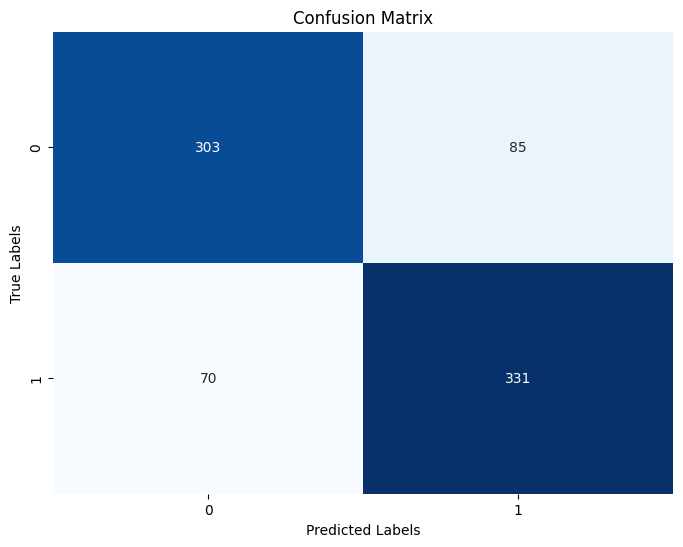

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualizing the classification matrix with number of folds set to 11.
# We see 303 true negatives, 70 false negatives, 85 false positives, & 331 true positives.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [53]:
# The classification report shows accuracy, the ratio of correct predictions to total predictions;
# precision, our focus when minimizing false positives; and recall, our focus when minimizing false negatives.
# Our goal is to not overlook any negative sentiment, so we want to minimize false positives.

print(f"Classification Report - Fold {len(classification_reports)}:\n{cr}")

Classification Report - Fold 11:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       388
           1       0.80      0.83      0.81       401

    accuracy                           0.80       789
   macro avg       0.80      0.80      0.80       789
weighted avg       0.80      0.80      0.80       789

